Import all required libraries 

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
#from google.colab import files 
%matplotlib inline

In [8]:
# data containing defect images with segmentation mask 
defect_class_mask_df = pd.read_csv(r'C:\Users\FLUXNATURE\Desktop\Old Desktop Ismail\JUNE MUN626\the 6 real world examples\6. Maintenance Department\train.csv')


In [10]:
# data containing defective and non defective images
all_images_df = pd.read_csv(r'C:\Users\FLUXNATURE\Desktop\Old Desktop Ismail\JUNE MUN626\the 6 real world examples\6. Maintenance Department\defect_and_no_defect.csv')


In [11]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


In [12]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [14]:
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [15]:
defect_class_mask_df.head(50)

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
5,17d02873a.jpg,3,254980 43 255236 127 255492 211 255748 253 256...,1
6,47b5ab1bd.jpg,3,128976 8 129230 12 129484 16 129739 23 129995 ...,1
7,a6ecee828.jpg,3,179011 27 179126 73 179259 39 179375 80 179497...,1
8,11aaf18e2.jpg,3,303235 2 303489 7 303743 9 303997 11 304181 2 ...,1
9,cdf669a1f.jpg,4,310246 11 310499 25 310753 28 311007 31 311262...,1


Text(0.5, 1.0, 'Number of images per class')

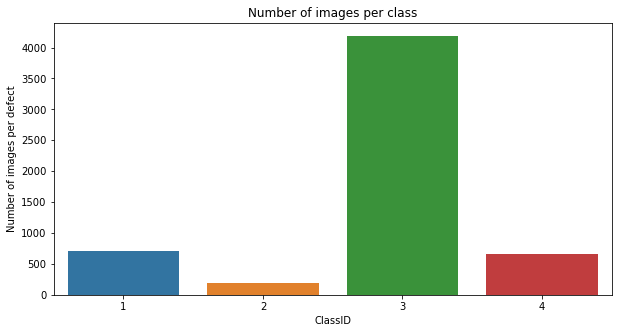

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(defect_class_mask_df['ClassId'])
plt.ylabel('Number of images per defect')
plt.xlabel('ClassID')
plt.title('Number of images per class')

In [18]:
# Some images are classified with more than one defect, let's explore this futher
# we have one image with 3 types of defects 
# we have 272 images with 2 types of defects
# we have 5201 images with 1 type of defect
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()

In [19]:
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

In [21]:
defect_type.value_counts()

1    5201
2     272
3       1
Name: mask, dtype: int64

Text(0.5, 1.0, 'Number of defects in image')

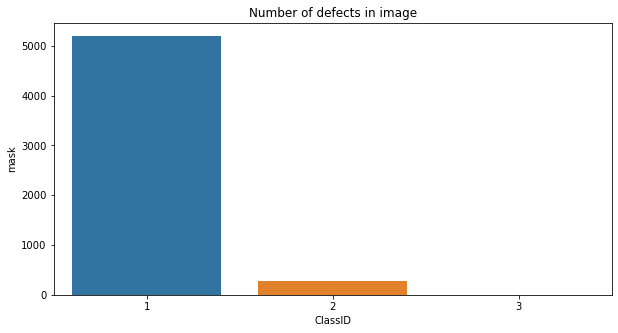

In [22]:
plt.figure(figsize=(10,5))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts() )
plt.xlabel('ClassID')
plt.title('Number of defects in image')

In [23]:
defect_class_mask_df.shape

(5748, 4)

In [24]:
all_images_df.shape

(12997, 2)

In [25]:
# Let's count defective and non defective images
all_images_df.label.value_counts()

1    7095
0    5902
Name: label, dtype: int64

Text(0.5, 1.0, 'Defect and non-defect images')

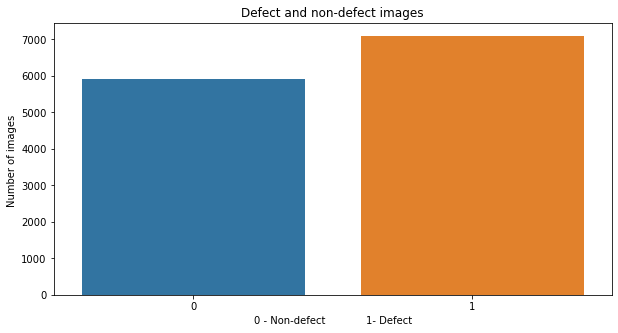

In [27]:
plt.figure(figsize=(10,5))
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts() )
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Defect and non-defect images')

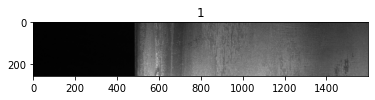

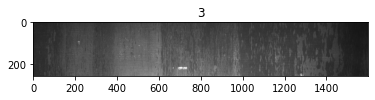

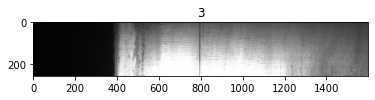

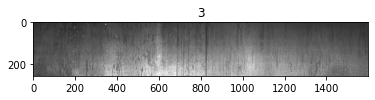

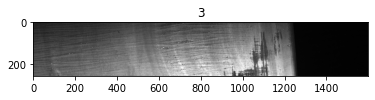

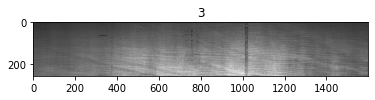

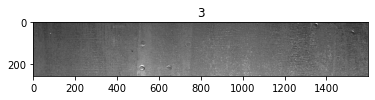

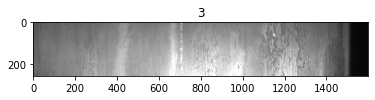

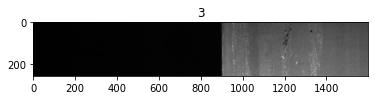

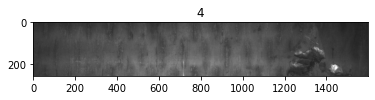

In [30]:
# Visualize images with defects along with their corresponding labels
# Images are 256 x 1600
#from cv2 import cv2_imshow
train_dir = 'C:/Users/FLUXNATURE/Desktop/Old Desktop Ismail/JUNE MUN626/the 6 real world examples/6. Maintenance Department/train_images/'

for i in range(10):
  # Specify the path to the images given their image ID
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  plt.figure()
  plt.title(defect_class_mask_df.ClassId[i])
  plt.imshow(img)

In [32]:
# Utilities file contains the code for rle2mask, mask2rle, custom loss function and custom data generator
# since the data provided for segmentation is in RLE format (run length encoded), we will be using the following function to convert the RLE to mask. 
# we can convert the mask back again to RLE to assess model performance (accuracy).
# Code source for these function came from: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

%cd C:\Users\FLUXNATURE\Desktop\Old Desktop Ismail\JUNE MUN626\the 6 real world examples\6. Maintenance Department
from utilities import rle2mask , mask2rle

train_dir = 'C:/Users/FLUXNATURE/Desktop/Old Desktop Ismail/JUNE MUN626/the 6 real world examples/6. Maintenance Department/train_images/'

C:\Users\FLUXNATURE\Desktop\Old Desktop Ismail\JUNE MUN626\the 6 real world examples\6. Maintenance Department


In [33]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
...,...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...,1
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...,1
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...,1
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...,1


In [34]:
# Let's try to use the rle2mask on a sample image 
image_index = 20 #20 30
mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index], img.shape[0], img.shape[1])
mask.shape

(256, 1600)

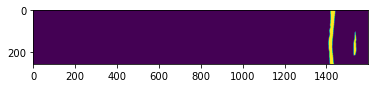

In [35]:
# Let's show the mask
plt.imshow(mask)

(256, 1600, 3)

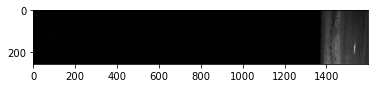

In [36]:
img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[image_index]))
plt.imshow(img)
img.shape

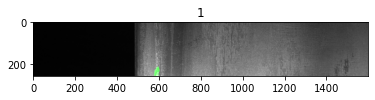

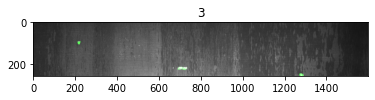

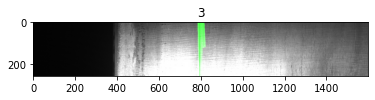

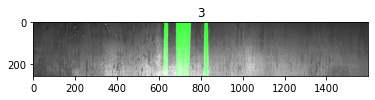

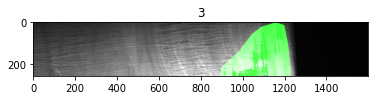

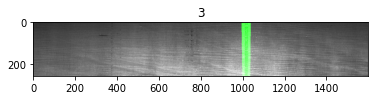

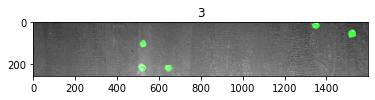

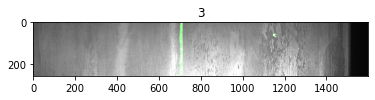

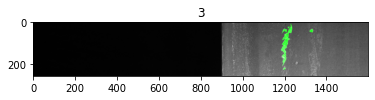

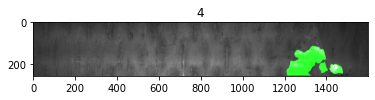

In [37]:
for i in range(10):

  # Read the images using opencv and converting to rgb format
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Get the mask for the image from rle
  mask = rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])
  
  # Let's color the pixels with values = 1 
  img[mask == 1,1] = 255
  plt.figure()
  plt.imshow(img)
  plt.title(defect_class_mask_df.ClassId[i])

In [38]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [39]:
# split the data (defective and non defective) into training and testing 
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size=0.15)

In [40]:
train.shape

(11047, 2)

In [41]:
test.shape

(1950, 2)

In [42]:
train_dir = 'C:/Users/FLUXNATURE/Desktop/Old Desktop Ismail/JUNE MUN626/the 6 real world examples/6. Maintenance Department/train_images/'

In [43]:
# create a image generator for the training and validation dataset
# we will divide the data to training, validation and testing
# Training = 9390 
# validation = 1657 
# testing = 1950 

from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "training",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))


valid_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "validation",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))

Found 9390 validated image filenames.
Found 1657 validated image filenames.


In [44]:
# Create a data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = train_dir,
x_col = "ImageID",
y_col = None,
batch_size = 16,
shuffle = False,
class_mode = None,
target_size = (256, 256))

Found 1950 validated image filenames.


In [45]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

In [46]:
basemodel.summary()

n[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 32, 32, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 16, 16, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 16, 16, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 16, 16, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 16, 16, 256)  590080      conv4_block1_1_relu[0][0] 

In [47]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [48]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [49]:
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [50]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="resnet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
# (WARNING TAKES LONG TIME (~90 mins)!)
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])